In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score



import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



In [2]:
ruta = r'C:\docs\DOCTORADO\Machine_Learning/tornados.csv'  
df = pd.read_csv(ruta) 


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\docs\\DOCTORADO\\Machine_Learning/tornados.csv'

## Máquinas de soporte vectorial (SVM)

In [268]:
import time
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, classification_report
)
import pandas as pd

# 1. Instanciamos el modelo SVM con kernel lineal
svm_linear = SVC(kernel='linear', probability=True, random_state=42)

# 2. Medir tiempo de entrenamiento
start_time = time.time()
svm_linear.fit(X_train_scaled, y_train)
tiempo_entrenamiento = time.time() - start_time

# 3. Predecimos etiquetas y probabilidades
y_pred_svm = svm_linear.predict(X_test_scaled)
y_prob_svm = svm_linear.predict_proba(X_test_scaled)[:, 1]

# 4. Evaluamos y guardamos métricas
resultados_svm_linear = pd.DataFrame({
    'Modelo': ['SVM (kernel linear, sin SMOTE)'],
    'Accuracy': [round(accuracy_score(y_test, y_pred_svm), 4)],
    'Precision': [round(precision_score(y_test, y_pred_svm), 4)],
    'Recall': [round(recall_score(y_test, y_pred_svm), 4)],
    'F1-score': [round(f1_score(y_test, y_pred_svm), 4)],
    'AUC': [round(roc_auc_score(y_test, y_prob_svm), 4)],
    'CPU time (s)': [round(tiempo_entrenamiento, 4)]
})

# 5. Mostrar resultados
print("📊 Matriz de Confusión:\n", confusion_matrix(y_test, y_pred_svm))
print("\n📋 Reporte de Clasificación:\n", classification_report(y_test, y_pred_svm))
display(resultados_svm_linear)



📊 Matriz de Confusión:
 [[12026     0]
 [  394    36]]

📋 Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98     12026
           1       1.00      0.08      0.15       430

    accuracy                           0.97     12456
   macro avg       0.98      0.54      0.57     12456
weighted avg       0.97      0.97      0.96     12456



,Modelo,Accuracy,Precision,Recall,F1-score,AUC,CPU time (s)
0,"SVM (kernel linear, sin SMOTE)",0.9684,1.0,0.0837,0.1545,0.9016,38.0802


Al analizar los datos se observa: 

 Este modelo parece sobresaliente a primera vista por su accuracy y precisión perfectas, pero tiene un grave problema: detecta apenas el 8% de las muertes reales. Esto significa que ignora el 92% de los casos verdaderamente peligrosos, lo cual es totalmente inaceptable en este contexto. Su alto accuracy se debe al gran desbalance de clases. El tiempo de cómputo es considerable, pero el bajo recall lo descalifica como opción viable.

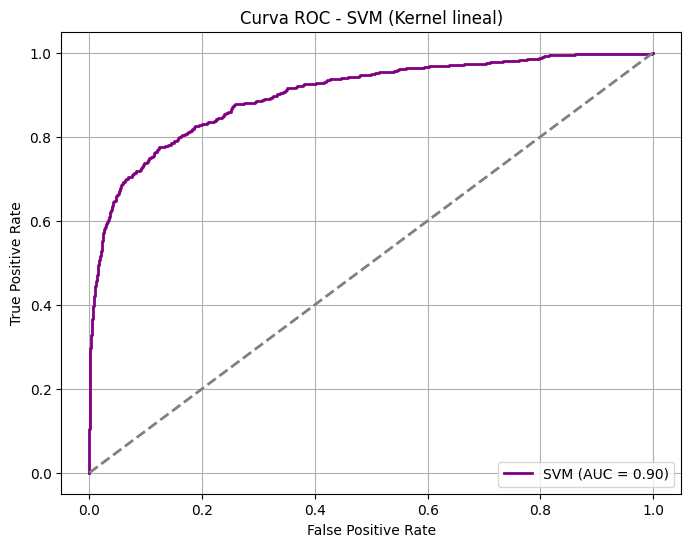

In [269]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calcular FPR, TPR y AUC para el SVM
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_prob_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

# Graficar
plt.figure(figsize=(8,6))
plt.plot(fpr_svm, tpr_svm, color='purple', lw=2, label='SVM (AUC = %0.2f)' % roc_auc_svm)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - SVM (Kernel lineal)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

La curva ROC del modelo SVM con kernel lineal muestra un AUC de 0.90, lo cual en apariencia sugiere una muy buena capacidad para discriminar entre tornados con y sin víctimas mortales. Sin embargo, esta impresión positiva se desmiente al observar las métricas detalladas del modelo: aunque la accuracy es alta (0.9684) y la precision es perfecta (1.0), el recall es extremadamente bajo (0.0837), lo que significa que el modelo solo identifica correctamente el 8.3% de los casos con muertes reales. Esto se traduce en un F1-score de apenas 0.1545. En términos prácticos, el modelo evita falsos positivos a toda costa, pero a cambio deja pasar la mayoría de los eventos críticos que sí causaron muertes. En contextos donde lo más importante es anticipar y salvar vidas, este comportamiento es inaceptable, y por tanto, el modelo resulta inadecuado a pesar de su buena curva ROC.

## SVM class_weight='balanced

Aplicaremos class_weight='balanced' para buscar un mejor recall para la clase 1:

In [278]:
import time
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, classification_report
)
import pandas as pd

# 1. Instanciar el modelo con balanceo de clases
svm_balanced = SVC(kernel='linear', probability=True, class_weight='balanced', random_state=42)

# 2. Medir tiempo de entrenamiento
start_time = time.time()
svm_balanced.fit(X_train_scaled, y_train)
tiempo_entrenamiento = time.time() - start_time

# 3. Predecir etiquetas y probabilidades
y_pred_svm_bal = svm_balanced.predict(X_test_scaled)
y_prob_svm_bal = svm_balanced.predict_proba(X_test_scaled)[:, 1]

# 4. Evaluar y guardar métricas
resultados_svm_bal = pd.DataFrame({
    'Modelo': ['SVM (kernel linear, class_weight=balanced)'],
    'Accuracy': [round(accuracy_score(y_test, y_pred_svm_bal), 4)],
    'Precision': [round(precision_score(y_test, y_pred_svm_bal), 4)],
    'Recall': [round(recall_score(y_test, y_pred_svm_bal), 4)],
    'F1-score': [round(f1_score(y_test, y_pred_svm_bal), 4)],
    'AUC': [round(roc_auc_score(y_test, y_prob_svm_bal), 4)],
    'CPU time (s)': [round(tiempo_entrenamiento, 4)]
})

# 5. Mostrar resultados
print("📊 Matriz de Confusión:\n", confusion_matrix(y_test, y_pred_svm_bal))
print("\n📋 Reporte de Clasificación:\n", classification_report(y_test, y_pred_svm_bal))
print (resultados_svm_bal)
display(resultados_svm_bal)


📊 Matriz de Confusión:
 [[10842  1184]
 [   68   362]]

📋 Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.99      0.90      0.95     12026
           1       0.23      0.84      0.37       430

    accuracy                           0.90     12456
   macro avg       0.61      0.87      0.66     12456
weighted avg       0.97      0.90      0.93     12456

                                       Modelo  Accuracy  Precision  Recall  \
0  SVM (kernel linear, class_weight=balanced)    0.8995     0.2342  0.8419   

   F1-score     AUC  CPU time (s)  
0    0.3664  0.9394      196.9632  


,Modelo,Accuracy,Precision,Recall,F1-score,AUC,CPU time (s)
0,"SVM (kernel linear, class_weight=balanced)",0.8995,0.2342,0.8419,0.3664,0.9394,196.9632


Este modelo sobresale en recall, siendo de los que mejor identifica las muertes (84%). No obstante, su baja precisión sugiere que también genera muchas falsas alarmas. En un contexto donde lo más importante es no dejar pasar eventos con víctimas, es preferible tener este tipo de error. Sin embargo, el costo computacional es alto (197 s), lo que puede limitar su uso en entornos de tiempo real.

## SVM balanceado con SMOTE

Ahora vamos a probar con Smote

In [272]:
from imblearn.over_sampling import SMOTE # type: ignore
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, classification_report
)
import pandas as pd
import time  # <-- Para medir el tiempo

# 1. Aplicar SMOTE
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# 2. Escalar los datos
scaler = StandardScaler()
X_train_sm_scaled = scaler.fit_transform(X_train_sm)
X_test_scaled = scaler.transform(X_test)

# 3. Instanciar y entrenar el modelo SVM con medición de tiempo
start_time = time.time()

svm_smote = SVC(kernel='linear', probability=True, random_state=42)
svm_smote.fit(X_train_sm_scaled, y_train_sm)

end_time = time.time()
tiempo_entrenamiento = end_time - start_time

# 4. Predecir
y_pred = svm_smote.predict(X_test_scaled)
y_prob = svm_smote.predict_proba(X_test_scaled)[:, 1]

# 5. Evaluar métricas y registrar resultados
resultados_svm_smote = pd.DataFrame({
    'Modelo': ['SVM (kernel linear, con SMOTE)'],
    'Accuracy': [round(accuracy_score(y_test, y_pred), 4)],
    'Precision': [round(precision_score(y_test, y_pred), 4)],
    'Recall': [round(recall_score(y_test, y_pred), 4)],
    'F1-score': [round(f1_score(y_test, y_pred), 4)],
    'AUC': [round(roc_auc_score(y_test, y_prob), 4)],
    'CPU time (s)': [round(tiempo_entrenamiento, 4)]
})

# 6. Mostrar resultados
print("📊 Matriz de Confusión:\n", confusion_matrix(y_test, y_pred))
print("\n📋 Reporte de Clasificación:\n", classification_report(y_test, y_pred))
display(resultados_svm_smote)



📊 Matriz de Confusión:
 [[11939    87]
 [  249   181]]

📋 Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99     12026
           1       0.68      0.42      0.52       430

    accuracy                           0.97     12456
   macro avg       0.83      0.71      0.75     12456
weighted avg       0.97      0.97      0.97     12456



,Modelo,Accuracy,Precision,Recall,F1-score,AUC,CPU time (s)
0,"SVM (kernel linear, con SMOTE)",0.973,0.6754,0.4209,0.5186,0.929,144.9095


Este modelo logra el mejor equilibrio entre recall y precisión, con el F1-score más alto de todos. Aunque no tiene el mejor recall absoluto, detecta casi la mitad de las muertes con una precisión aceptable, lo que lo convierte en un excelente compromiso. El alto AUC y la robustez del modelo lo hacen confiable, aunque su tiempo de cómputo (144 s) sigue siendo alto.

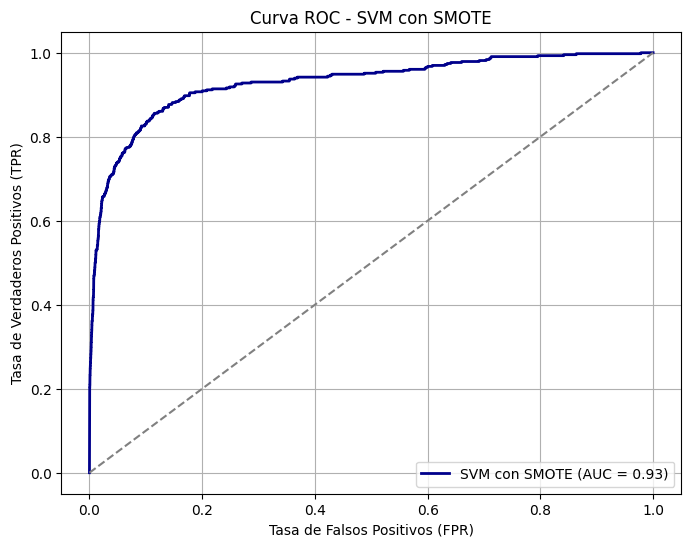

In [273]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# 1. Calcular la curva ROC y AUC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# 2. Graficar la curva ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkblue', lw=2, label='SVM con SMOTE (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=1.5, linestyle='--')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - SVM con SMOTE')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


En problemas como este, relacionados con eventos críticos (como muertes por tornados), la prioridad es detectar todos los casos posibles que puedan representar una amenaza. Esto implica que los falsos negativos deben minimizarse, ya que no identificar un caso de muerte cuando realmente ocurre puede tener consecuencias graves.

Por eso, Recall (sensibilidad) es la métrica más importante en este contexto: mide la proporción de verdaderos positivos correctamente identificados.

Aunque el modelo puede tener alta precisión o exactitud general (accuracy), si falla en detectar los positivos (muertes), no sería útil desde el punto de vista práctico o de negocio.

## Aplicación de algoritmos de optimización 


### SGD SVM SGDClassifier (descenso de gradiente estocástico)

In [274]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, classification_report
)
import time
import pandas as pd

# 1. Instanciar modelo SGDClassifier como SVM lineal
sgd_svm = SGDClassifier(loss='hinge', random_state=42)

# 2. Medir tiempo de entrenamiento
start_time = time.time()
sgd_svm.fit(X_train_scaled, y_train)
tiempo_entrenamiento = time.time() - start_time

# 3. Predecir
y_pred_sgd = sgd_svm.predict(X_test_scaled)

# 4. Probabilidades (usamos decision_function para aproximar AUC)
y_scores = sgd_svm.decision_function(X_test_scaled)

# 5. Evaluar y mostrar resultados
print("📊 Matriz de Confusión:\n", confusion_matrix(y_test, y_pred_sgd))
print("\n📋 Reporte de Clasificación:\n", classification_report(y_test, y_pred_sgd))

# 6. Crear DataFrame con métricas
resultados_sgd_svm = pd.DataFrame({
    'Modelo': ['SVM con SGDClassifier'],
    'Accuracy': [round(accuracy_score(y_test, y_pred_sgd), 4)],
    'Precision': [round(precision_score(y_test, y_pred_sgd, zero_division=0), 4)],
    'Recall': [round(recall_score(y_test, y_pred_sgd), 4)],
    'F1-score': [round(f1_score(y_test, y_pred_sgd), 4)],
    'AUC': [round(roc_auc_score(y_test, y_scores), 4)],
    'CPU time (s)': [round(tiempo_entrenamiento, 4)]
})

# 7. Mostrar métricas en tabla
print("\n📈 Resultados:")
display(resultados_sgd_svm)


📊 Matriz de Confusión:
 [[12023     3]
 [  370    60]]

📋 Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98     12026
           1       0.95      0.14      0.24       430

    accuracy                           0.97     12456
   macro avg       0.96      0.57      0.61     12456
weighted avg       0.97      0.97      0.96     12456


📈 Resultados:


,Modelo,Accuracy,Precision,Recall,F1-score,AUC,CPU time (s)
0,SVM con SGDClassifier,0.9701,0.9524,0.1395,0.2434,0.8548,0.1687


Este modelo es muy conservador, similar al SVM sin SMOTE. Prefiere no equivocarse al predecir muertes (alta precisión), pero detecta muy pocas. Es más rápido (0.16 s), pero su bajo recall lo hace inapropiado si el objetivo es proteger vidas.

### LinearSVC

In [275]:
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, classification_report
)
from sklearn.calibration import CalibratedClassifierCV
import pandas as pd
import time

# Medir tiempo de entrenamiento
inicio = time.time()

# Entrenamos con LinearSVC (no tiene predict_proba, así que usamos CalibratedClassifierCV)
linear_svc_base = LinearSVC(random_state=42, max_iter=10000)
calibrated_svc = CalibratedClassifierCV(linear_svc_base, cv=5)
calibrated_svc.fit(X_train_scaled, y_train)

fin = time.time()
tiempo_entrenamiento = fin - inicio

# Predecir
y_pred_linear_svc = calibrated_svc.predict(X_test_scaled)
y_prob_linear_svc = calibrated_svc.predict_proba(X_test_scaled)[:, 1]

# Guardar métricas
resultados_linear_svc = pd.DataFrame({
    'Modelo': ['LinearSVC (con calibración)'],
    'Accuracy': [round(accuracy_score(y_test, y_pred_linear_svc), 4)],
    'Precision': [round(precision_score(y_test, y_pred_linear_svc), 4)],
    'Recall': [round(recall_score(y_test, y_pred_linear_svc), 4)],
    'F1-score': [round(f1_score(y_test, y_pred_linear_svc), 4)],
    'AUC': [round(roc_auc_score(y_test, y_prob_linear_svc), 4)],
    'CPU time (s)': [round(tiempo_entrenamiento, 4)]
})

# Verificar matriz y reporte si quieres
print("📊 Matriz de Confusión:\n", confusion_matrix(y_test, y_pred_linear_svc))
print("\n📋 Reporte de Clasificación:\n", classification_report(y_test, y_pred_linear_svc))

display(resultados_linear_svc)

📊 Matriz de Confusión:
 [[12024     2]
 [  378    52]]

📋 Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98     12026
           1       0.96      0.12      0.21       430

    accuracy                           0.97     12456
   macro avg       0.97      0.56      0.60     12456
weighted avg       0.97      0.97      0.96     12456



,Modelo,Accuracy,Precision,Recall,F1-score,AUC,CPU time (s)
0,LinearSVC (con calibración),0.9695,0.963,0.1209,0.2149,0.919,3.4848


Al igual que el anterior, este modelo tiene excelente precisión, pero muy bajo recall. Calibrar el modelo mejora la probabilidad estimada, pero no cambia su comportamiento general: no detecta suficientes muertes. Aunque más rápido que otros SVM, no cumple con el objetivo del problema.

### RBF con Random Fourier Features

In [276]:
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, classification_report
)
import pandas as pd
import time

# Escalarlos  datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 1. Crear pipeline con RBFSampler y SGDClassifier
rbf_feature = RBFSampler(gamma=1, random_state=42)
clf_rbf_sgd = make_pipeline(rbf_feature, SGDClassifier(max_iter=1000, tol=1e-3, random_state=42))

# 2. Entrenar el modelo y registrar tiempo de CPU
start_time = time.time()
clf_rbf_sgd.fit(X_train_scaled, y_train)
training_time = time.time() - start_time

# 3. Predecir en el conjunto de prueba
y_pred_rbf = clf_rbf_sgd.predict(X_test_scaled)
y_score_rbf = clf_rbf_sgd.decision_function(X_test_scaled)  # Necesario para AUC

# 4. Calcular métricas
accuracy = round(accuracy_score(y_test, y_pred_rbf), 4)
precision = round(precision_score(y_test, y_pred_rbf), 4)
recall = round(recall_score(y_test, y_pred_rbf), 4)
f1 = round(f1_score(y_test, y_pred_rbf), 4)
auc = round(roc_auc_score(y_test, y_score_rbf), 4)

# 5. Crear DataFrame con resultados
resultados_rbf = pd.DataFrame({
    'Modelo': ['SVM (RBF approx con Random Fourier)'],
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1-score': [f1],
    'AUC': [auc],
    'CPU time (s)': [round(training_time, 4)]
})

# 6. Mostrar matriz de confusión y reporte
print("📊 Matriz de Confusión:\n", confusion_matrix(y_test, y_pred_rbf))
print("\n📋 Reporte de Clasificación:\n", classification_report(y_test, y_pred_rbf))

# 7. Ver resultados en tabla
resultados_rbf


📊 Matriz de Confusión:
 [[12026     0]
 [  430     0]]

📋 Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98     12026
           1       0.00      0.00      0.00       430

    accuracy                           0.97     12456
   macro avg       0.48      0.50      0.49     12456
weighted avg       0.93      0.97      0.95     12456



,Modelo,Accuracy,Precision,Recall,F1-score,AUC,CPU time (s)
0,SVM (RBF approx con Random Fourier),0.9655,0.0,0.0,0.0,0.502,0.1191


El modelo falló por completo al clasificar correctamente la clase minoritaria. Posiblemente se debe a una mala configuración del kernel aproximado o problemas con la transformación random Fourier. Totalmente descartado.

